In [60]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import uuid

In [61]:
import math
import cv2
import numpy as np


def angle_difference(x, y):
    """
    Calculate minimum difference between two angles.
    """
    return 180 - abs(abs(x - y) - 180)

def binarize_images(x):
    """
    Convert images to range 0-1 and binarize them by making
    0 the values below 0.1 and 1 the values above 0.1.
    """
    x /= 255
    x[x >= 0.1] = 1
    x[x < 0.1] = 0
    return x


def rotate(image, angle):
    """
    Rotates an OpenCV 2 / NumPy image about it's centre by the given angle
    (in degrees). The returned image will be large enough to hold the entire
    new image, with a black background

    Source: http://stackoverflow.com/questions/16702966/rotate-image-and-crop-out-black-borders
    """
    # Get the image size
    # No that's not an error - NumPy stores image matricies backwards
    image_size = (image.shape[1], image.shape[0])
    image_center = tuple(np.array(image_size) / 2)

    # Convert the OpenCV 3x2 rotation matrix to 3x3
    rot_mat = np.vstack(
        [cv2.getRotationMatrix2D(image_center, angle, 1.0), [0, 0, 1]]
    )

    rot_mat_notranslate = np.matrix(rot_mat[0:2, 0:2])

    # Shorthand for below calcs
    image_w2 = image_size[0] * 0.5
    image_h2 = image_size[1] * 0.5

    # Obtain the rotated coordinates of the image corners
    rotated_coords = [
        (np.array([-image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([-image_w2, -image_h2]) * rot_mat_notranslate).A[0],
        (np.array([image_w2, -image_h2]) * rot_mat_notranslate).A[0]
    ]

    # Find the size of the new image
    x_coords = [pt[0] for pt in rotated_coords]
    x_pos = [x for x in x_coords if x > 0]
    x_neg = [x for x in x_coords if x < 0]

    y_coords = [pt[1] for pt in rotated_coords]
    y_pos = [y for y in y_coords if y > 0]
    y_neg = [y for y in y_coords if y < 0]

    right_bound = max(x_pos)
    left_bound = min(x_neg)
    top_bound = max(y_pos)
    bot_bound = min(y_neg)

    new_w = int(abs(right_bound - left_bound))
    new_h = int(abs(top_bound - bot_bound))

    # We require a translation matrix to keep the image centred
    trans_mat = np.matrix([
        [1, 0, int(new_w * 0.5 - image_w2)],
        [0, 1, int(new_h * 0.5 - image_h2)],
        [0, 0, 1]
    ])

    # Compute the tranform for the combined rotation and translation
    affine_mat = (np.matrix(trans_mat) * np.matrix(rot_mat))[0:2, :]

    # Apply the transform
    result = cv2.warpAffine(
        image,
        affine_mat,
        (new_w, new_h),
        flags=cv2.INTER_LINEAR
    )

    return result


def largest_rotated_rect(w, h, angle):
    """
    Given a rectangle of size wxh that has been rotated by 'angle' (in
    radians), computes the width and height of the largest possible
    axis-aligned rectangle within the rotated rectangle.

    Original JS code by 'Andri' and Magnus Hoff from Stack Overflow

    Converted to Python by Aaron Snoswell

    Source: http://stackoverflow.com/questions/16702966/rotate-image-and-crop-out-black-borders
    """

    quadrant = int(math.floor(angle / (math.pi / 2))) & 3
    sign_alpha = angle if ((quadrant & 1) == 0) else math.pi - angle
    alpha = (sign_alpha % math.pi + math.pi) % math.pi

    bb_w = w * math.cos(alpha) + h * math.sin(alpha)
    bb_h = w * math.sin(alpha) + h * math.cos(alpha)

    gamma = math.atan2(bb_w, bb_w) if (w < h) else math.atan2(bb_w, bb_w)

    delta = math.pi - alpha - gamma

    length = h if (w < h) else w

    d = length * math.cos(alpha)
    a = d * math.sin(alpha) / math.sin(delta)

    y = a * math.cos(gamma)
    x = y * math.tan(gamma)

    return (
        bb_w - 2 * x,
        bb_h - 2 * y
    )


def crop_around_center(image, width, height):
    """
    Given a NumPy / OpenCV 2 image, crops it to the given width and height,
    around it's centre point

    Source: http://stackoverflow.com/questions/16702966/rotate-image-and-crop-out-black-borders
    """

    image_size = (image.shape[1], image.shape[0])
    image_center = (int(image_size[0] * 0.5), int(image_size[1] * 0.5))

    if (width > image_size[0]):
        width = image_size[0]

    if (height > image_size[1]):
        height = image_size[1]

    x1 = int(image_center[0] - width * 0.5)
    x2 = int(image_center[0] + width * 0.5)
    y1 = int(image_center[1] - height * 0.5)
    y2 = int(image_center[1] + height * 0.5)

    return image[y1:y2, x1:x2]


def crop_largest_rectangle(image, angle, height, width):
    """
    Crop around the center the largest possible rectangle
    found with largest_rotated_rect.
    """
    return crop_around_center(
        image,
        *largest_rotated_rect(
            width,
            height,
            math.radians(angle)
        )
    )


def generate_rotated_image(image, angle, size=None, crop_center=False,
                           crop_largest_rect=False):
    """
    Generate a valid rotated image for the RotNetDataGenerator. If the
    image is rectangular, the crop_center option should be used to make
    it square. To crop out the black borders after rotation, use the
    crop_largest_rect option. To resize the final image, use the size
    option.
    """
    height, width = image.shape[:2]
    if crop_center:
        if width < height:
            height = width
        else:
            width = height

    image = rotate(image, angle)

    if crop_largest_rect:
        image = crop_largest_rectangle(image, angle, height, width)

    if size:
        image = cv2.resize(image, size)

    return image

In [62]:
def count_vertical_lines(image, angle_threshold=10, min_line_length=100, max_line_gap=10):
    vertical_line_img = image.copy()
    # Load the image in grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply edge detection (Canny is commonly used)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    
    # Apply Hough Line Transform to detect lines
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=100,
                            minLineLength=min_line_length, maxLineGap=max_line_gap)
    
    # Initialize a counter for vertical lines
    vertical_line_count = 0
    
    # Process each line found by HoughLinesP
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if x1 > x2:
                x1, x2 = x2, x1
                y1, y2 = y2, y1
            
            # Calculate the angle of the line
            angle = int(np.degrees(np.arctan2(x2 - x1, abs(y2 - y1))))
            
            # Check if the angle is within the vertical threshold
            if abs(angle) < angle_threshold:
                vertical_line_count += 1
                cv2.line(vertical_line_img, (x1, y1), (x2, y2), (0, 0, 255), 3)
    
    # cv2.imwrite(f"steps/vertical_lines_{uuid.uuid4()}.jpg", vertical_line_img)
    
    return vertical_line_count

In [63]:
def calculate_alignment_angle(image_path, output_path=None, rm_background=False):
    img = cv2.imread(image_path)
    if max(img.shape) > 500:
        img = cv2.resize(img, (500, 500 * img.shape[0] // img.shape[1]))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # cv2.imwrite("steps/gray.jpg", gray)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    lines_img = img.copy()
    filtered_lines_img = img.copy()
    # cv2.imwrite("steps/edges.jpg", edges)

    # Detect lines using Hough Transform
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 100,
                            minLineLength=100, maxLineGap=10)
    if lines is None:
        return 0

    left_angles = []
    right_angles = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x1 > x2:
            x1, x2 = x2, x1
            y1, y2 = y2, y1
        angle = int(np.degrees(np.arctan2(x2 - x1, abs(y2 - y1))))

        if abs(angle) <= 45:
            if y2 < y1:
                right_angles.append(angle)
            else:
                left_angles.append(angle)
            cv2.line(filtered_lines_img, (x1, y1), (x2, y2), (0, 0, 255) if y2 < y1 else (255, 0, 0), 2)
        cv2.line(lines_img, (x1, y1), (x2, y2), (0, 0, 255) if y2 < y1 else (255, 0, 0), 2)
            # cv2.putText(lines_img, f"{angle}", (x1, y1),
            #             cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

    # cv2.imwrite("steps/lines.jpg", lines_img)
    # cv2.imwrite("steps/filtered_lines.jpg", filtered_lines_img)
    img_shape = img.shape

    angle_1 = -np.mean(left_angles) if left_angles else 0
    angle_2 = np.mean(right_angles) if right_angles else 0

    print(f"Mean of left angles: {angle_1} degrees")
    print(f"Mean of right angles: {angle_2} degrees")

    rotate_img_1 = generate_rotated_image(
        img, angle_1, size=(img_shape[1], img_shape[0]), crop_largest_rect=True)
    rotate_img_2 = generate_rotated_image(img, angle_2, size=(img_shape[1], img_shape[0]), crop_largest_rect=True)
    # cv2.imwrite("steps/right_rotated.jpg", rotate_img_1)
    # cv2.imwrite("steps/left_rotated.jpg", rotate_img_2)

    count_vertical_lines_1 = count_vertical_lines(rotate_img_1)
    count_vertical_lines_2 = count_vertical_lines(rotate_img_2)
    print("Number of vertical lines of left rotated image: ", count_vertical_lines_2)
    print("Number of vertical lines of right rotated image: ", count_vertical_lines_1)

    # print(f"count_vertical_lines_1: {count_vertical_lines_1}")
    # print(f"count_vertical_lines_2: {count_vertical_lines_2}")

    if count_vertical_lines_1 > count_vertical_lines_2:
        if output_path:
            cv2.imwrite(output_path, rotate_img_1)
        return angle_1
    else:
        if output_path:    
            cv2.imwrite(output_path, rotate_img_2)
        return angle_2

In [64]:
def display(input_path, output_path):
    # Load images
    img1 = cv2.imread(input_path)
    img2 = cv2.imread(output_path)

    # Convert images from BGR to RGB format (OpenCV loads images in BGR)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    # Create a 1x2 subplot
    plt.figure(figsize=(10, 5))

    # Display the first image
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st position
    plt.imshow(img1)
    plt.title('Input Image')
    plt.axis('off')  # Hide axes

    # Display the second image
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd position
    plt.imshow(img2)
    plt.title('Rotated Image')
    plt.axis('off')  # Hide axes

    # Show the plot
    plt.tight_layout()
    plt.show()

In [65]:
import time

Mean of left angles: -34.0 degrees
Mean of right angles: 4.3 degrees
Number of vertical lines of left rotated image:  8
Number of vertical lines of right rotated image:  0
Align angle:  4.3
Time taken:  0.07175278663635254 seconds


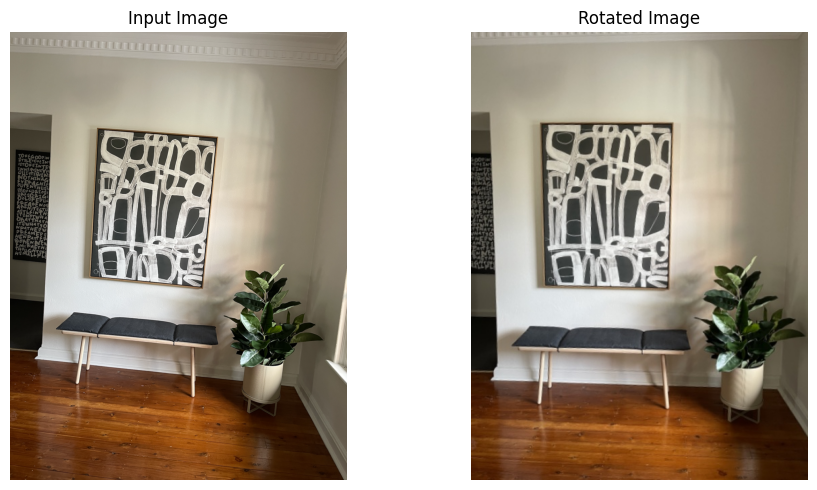

In [66]:
input_path = r"D:\Coding\CameraGuidance\Camera_Guide\poc\samples\Screen+Shot+2022-05-22+at+7.29.04+am.png"
output_path = "rotated_image.jpg"
start_time = time.time()
alignment_angle = calculate_alignment_angle(input_path, output_path)
end_time = time.time()
print("Align angle: ", alignment_angle)
print("Time taken: ", end_time - start_time, "seconds")

display(input_path, output_path)